# Tutorial Notebook for nisarhdf.nisarRIFGHDF
---

This notebook demonstrates the functionality of `nisarRIFGHDF`, which is at tool for reading NISAR **RIFG** products.  Some of its functionality is specifically developed for the Greenland Mapping Project (GrIMP) workflows, but it may also be of general use for working with these products. If nothing else, the source code provides examples of how to unpack these projects.

## Installation

The easiest way to ensure the code works is to create a custom environment using the *environment.yml* file included in this *nisarhdf* repository. To do so execute the following,

`conda env create -f environment.yml`

Then setup the kernel for the Jupyter notebooks with the command:

`python -m ipykernel install --user --name=nisarcryo`

Then activate the environment:

`conda activate nisarcryo`

Finally, start Jupyter and open the notebooks.

**Even if you want to work with your existing environment, the *environment.yml* file demonstrates which packages must be installed if they are not already present.**


## Python Imports

In [1]:
%load_ext autoreload
%autoreload 2
import nisarhdf
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import rioxarray
from osgeo import gdal

In [2]:
def autoScaleRange(myVar, percentile):
        '''
        If percentile less than 100, will select vmin as (100-percentile)
        and vmax as percentile of myVar, unless they fall out of the vmin and
        vmax bounds.
        Parameters
        ----------
        myVar : nparray
            Data being displayed.
        vmin : float
            Absolute minimum value.
        vmax : TYPE
            absolute maximum value.
        percentile : TYPE
            Clip data at (100-percentile) and percentile.

        Returns
        -------
        vmin, vmax - updated values based on percentiles.
        '''
        vmax = np.percentile(myVar[np.isfinite(myVar)], percentile)
        vmin = np.percentile(myVar[np.isfinite(myVar)], 100 - percentile)
        return vmin, vmax

In [3]:
def createDivider(ax, colorBarPosition='right', colorBarSize='5%',
                   colorBarPad=0.05):
    '''
    Create divider for color bar
    '''
    divider = make_axes_locatable(ax)  # Create space for colorbar
    return divider.append_axes(colorBarPosition, size=colorBarSize,
                               pad=colorBarPad)

def colorBar(pos, ax, colorBarLabel, colorBarPosition, colorBarSize,
              colorBarPad, labelFontSize, plotFontSize, extend='max',
              fontScale=1):
    '''
    Color bar for image
    '''
    # Create an divided axis for cb
    cbAx = createDivider(ax, colorBarPosition=colorBarPosition,
                             colorBarSize=colorBarSize,
                               colorBarPad=colorBarPad)
    # Select orientation
    orientation = {'right': 'vertical', 'left': 'vertical',
                   'top': 'horizontal',
                   'bottom': 'horizontal'}[colorBarPosition]

    cb = plt.colorbar(pos, cax=cbAx, orientation=orientation,
                      extend=extend)
    cb.set_label(colorBarLabel, size=labelFontSize * fontScale)
    cb.ax.tick_params(labelsize=plotFontSize * fontScale)
    if colorBarPosition in ['right', 'left']:
        cbAx.yaxis.set_ticks_position(colorBarPosition)
        cbAx.yaxis.set_label_position(colorBarPosition)
    elif colorBarPosition in ['top', 'tottom']:
        cbAx.xaxis.set_ticks_position(colorBarPosition)
        cbAx.xaxis.set_label_position(colorBarPosition)

## Open the HDF

Edit the path below to point to the ROFF product you wish to work with.

In [4]:
RIFGFile = '/Volumes/insar1/ian/NISAR/frame_280/insar/products/RIFG_ALOS2496725280-230804_ALOS2498795280-230818.h5'

Create an instance and open the hdf as shown below. For normal products, you shouldn't have to specify the orbit, but while the orbit fields are present in the example file, they are not populated. When you open the hdf, you can specify the precise orbit XMLs if desired, which are release a few weeks after the MOI orbits used in the processing.

In [5]:
myRIFG= nisarhdf.nisarRIFGHDF()
myRIFG.openHDF(RIFGFile , referenceOrbitXML=None, secondaryOrbitXML=None,
               referenceOrbit=49672, secondaryOrbit=49879, frame=5280)
myRIFG.SLCAzimuthPixelSize

ref orbit None
Could not open with page_buf_size, opening for non-optimized access
RIFG referenceZeroDopplerStartTime
alongTrackOffset
(1996, 857)
slantRangeOffset
(1996, 857)
correlationSurfacePeak
(1996, 857)
<class 'nisarhdf.nisarBaseHDF.pixelOffsets'>
[660125.36660615]
ref orbit None
Cannot sread secondary orbit yet
RIFG secondaryZeroDopplerStartTime
[660048.014999]


2.2716394524093184

## RIFG Parameters

A summary of some of the more important parameters for the **RIFG** products can be obtained by.

In [6]:
myRIFG.printParams()

RIFG.referenceOrbit = 49672 
RIFG.frame = 5280 
RIFG.datetime = 2023-08-04 14:57:47.166045 
RIFG.referenceGranule = rslc_ALOS2496725280-230804.h5 
RIFG.SLCNearRange = 814637.0 
RIFG.SLCFarRange = 852284.282920905 
RIFG.SLCFirstZeroDopplerTime = 53867.166045 
RIFG.SLCLastZeroDopplerTime = 53877.165933569675 
RIFG.secondaryOrbit = 49879 
RIFG.secondaryDatetime = 2023-08-18 14:57:47.171967 
RIFG.secondaryGranule = rslc_ALOS2498795280-230818.h5 
RIFG.LookDirection = right 
RIFG.PassType = descending 
RIFG.Wavelength = 0.23840349999999996 
RIFG.PRF = 3051.234 
RIFG.epsg = 3031 
RIFG.NumberRangeLooks = 13 
RIFG.NumberAzimuthLooks = 13 
RIFG.MLRangeSize = 2024 
RIFG.MLAzimuthSize = 2347 
RIFG.MLRangePixelSize = 18.59548911325529 
RIFG.MLAzimuthPixelSize = None
RIFG.MLZeroDopplerTimeSpacing = 0.004260571296727815 
RIFG.MLNearRange = 814645.582533437 
RIFG.MLFirstZeroDopplerTime = 53867.16801141752 
RIFG.MLIncidenceCenter = 39.84704795044878 

Data Fields
RIFG.coherenceMagnitude
RIFG.wrappedInt

For GrIMP, we extract all of the parameters needed to process and geocode the data, which are saved in geojson format. All parameters are releative to the reference image (`myRIFG.secondary.getGeojson()` provides equivalent information for the secondary). Most of the parameters below are self explanatory. Here are a few definitions:

 - `nominalTime` is the time of the first record in the SLC.
 - `TimeToFirstSLCSample` for NISAR this is always 0.0 (older custom processed images could have a different value).
 - `SkewOffset`, `Squint`, and `deltaT` are other time corrections in seconds that are always 0. for NISAR and are maintained for backwards compatability.
 - `CorrectedTime` gives the time to the first ML look sample in the unwrapped product.

All this information except the geometry information is available as a dictionary (`myRIFG.geodatDict`)

In [7]:
print(myRIFG.getGeojson())

{
  "type":"Feature",
  "geometry": {
    "type":"Polygon",
    "coordinates": [[[-76.494498, -106.590269], [-76.768685, -108.996847], [-76.289733, -109.936019], [-76.024656, -107.590501], [-76.494498, -106.590269]]]
  },
  "properties": {
    "ImageName":"RIFG_ALOS2496725280-230804_ALOS2498795280-230818.h5",
    "Date":"2023-08-04",
    "NominalTime":"14:57:47.168010",
    "NumberRangeLooks": 13,
    "NumberAzimuthLooks": 13,
    "MLRangeSize": 2024,
    "MLAzimuthSize": 2347,
    "PRF": 3051.234,
    "MLNearRange": 814645.582533437,
    "MLCenterRange": 833454.9197714947,
    "MLFarRange": 852264.2570095524,
    "RangeErrorCorrection": 0.0,
    "LookDirection":"right",
    "PassType":"descending",
    "CenterLatLon": [-76.3931359414256, -108.28444770298555],
    "TimeToFirstSLCSample": 0.0,
    "SkewOffset": 0.0,
    "Squint": 0.0,
    "EarthRadiusMajor": 6378137.0,
    "EarthRadiusMinor": 6356752.3142,
    "MLIncidenceCenter": 39.84704795044878,
    "SpaceCraftAltitude": 660125.3666

## Display Data

The RIFG products contain the `coherenceMagnitude` and the `wrappedInterferogram`, which can be displayed as

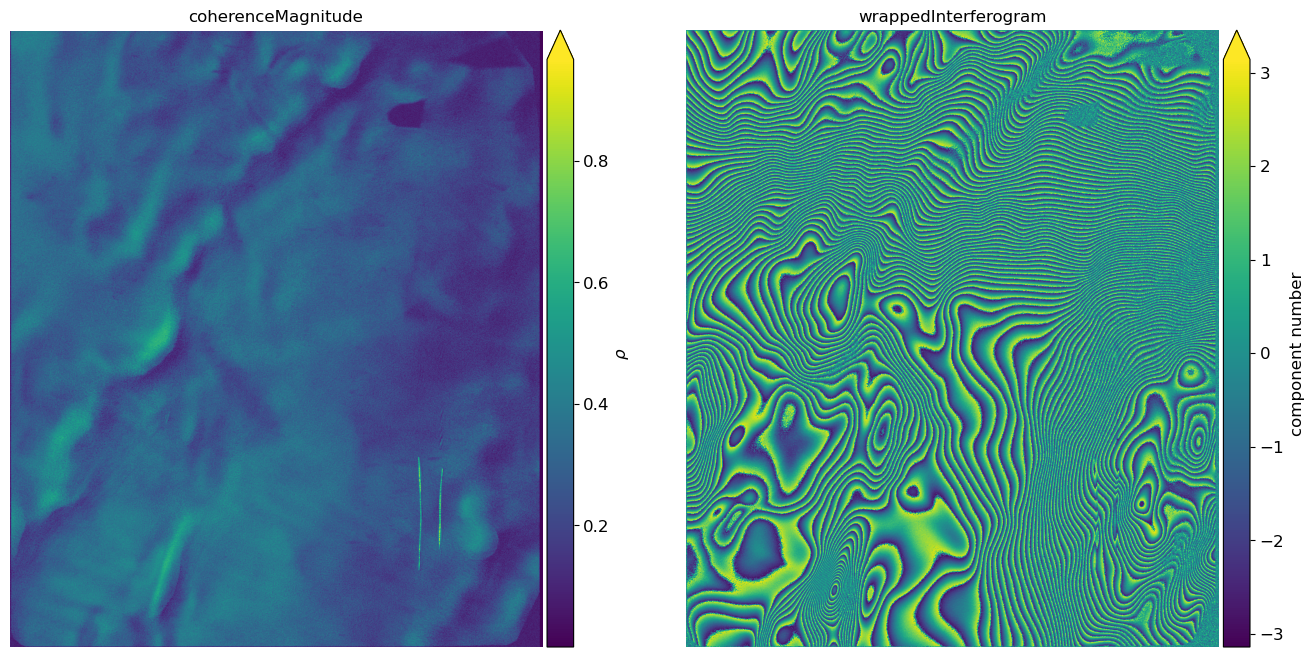

In [8]:
fields = myRIFG.dataFields 
labels = dict(zip(fields, ['$\\rho$', 'component number', 'phase (rad)', '$\\sigma$ (rad)', 'phase (rad)']))
fig, axes = plt.subplots(1, len(fields), figsize=(16, 10))
for field, ax in zip(fields, axes.flatten()):
    data = getattr(myRIFG, field)    
    if field == 'wrappedInterferogram':
        data = np.angle(data)
    #vmin, vmax = autoScaleRange(data, 95)
    h = ax.imshow(data, origin='lower')
    colorBar(h, ax, labels[field], 'right', '5%',.05, 12, 12)
    ax.set_title(field)
    ax.axis('off')

## Interferogram Offsets

The offsets used to compute the interferogram can be displayed as:

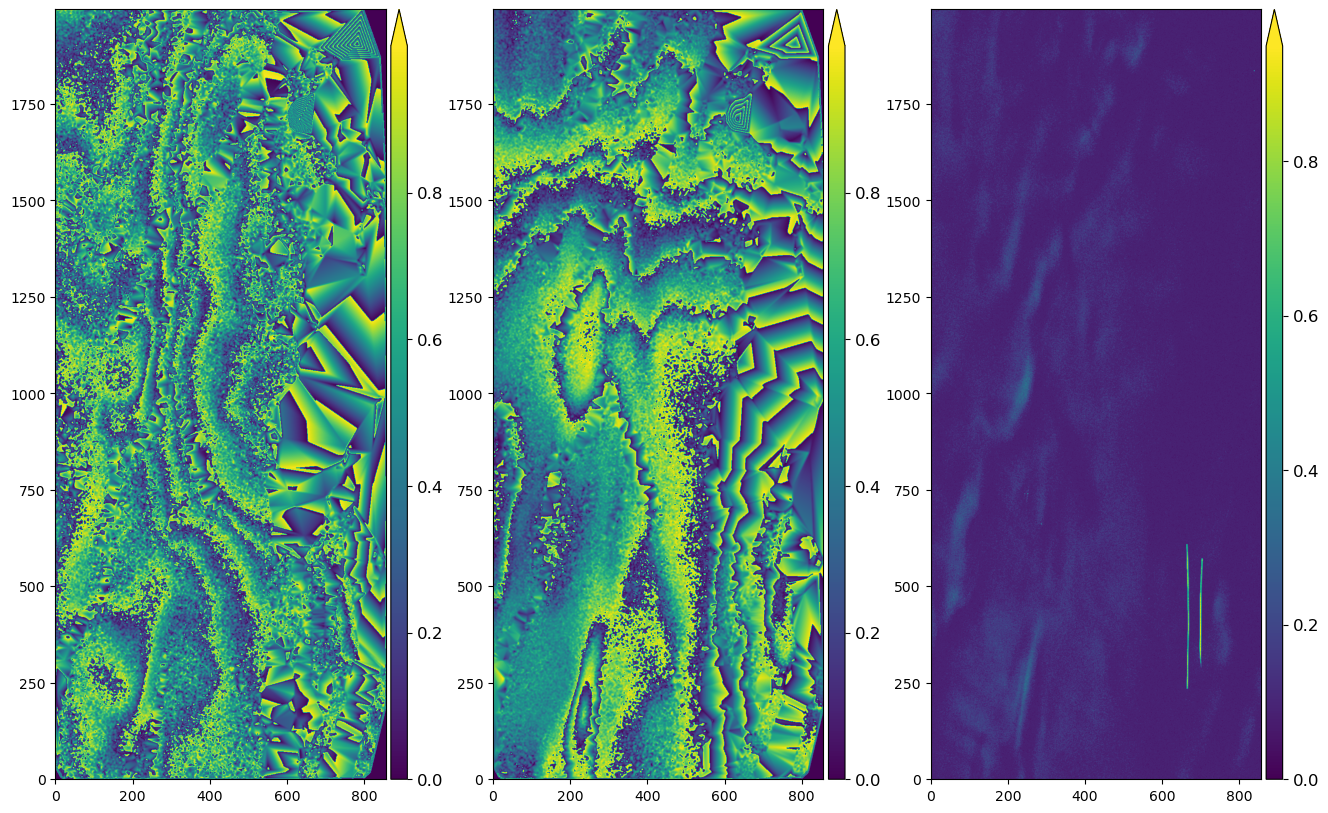

In [9]:
fig, axes = plt.subplots(1, len(myRIFG.pixelOffsets.dataFields), figsize=(16, 10))
for field, ax in zip(myRIFG.pixelOffsets.dataFields, axes.flatten()):
    data =   getattr(myRIFG.pixelOffsets, field) % 1
    h = ax.imshow(data, origin='lower')
    colorBar(h, ax, '', 'right', '5%',.05, 12, 12)

### Connected Components Masking

In general, the areas where the connected components are zero have data of questionable quality and its often better to mask them. 

In [10]:
myRIFG.maskPhase(largest=True)

Product type is RIFG but Method only works withROFF and GOFF


For this plot, we include the zero Doppler and slant range coordinates. Since we are viewing the product as increasing with time, the parameter `origin='lower'` is used. As a result, we need the extent for the lower-left corner, which is set as `extent=myRIFG.extentLL`.

AttributeError: 'nisarRIFGHDF' object has no attribute 'unwrappedPhase'

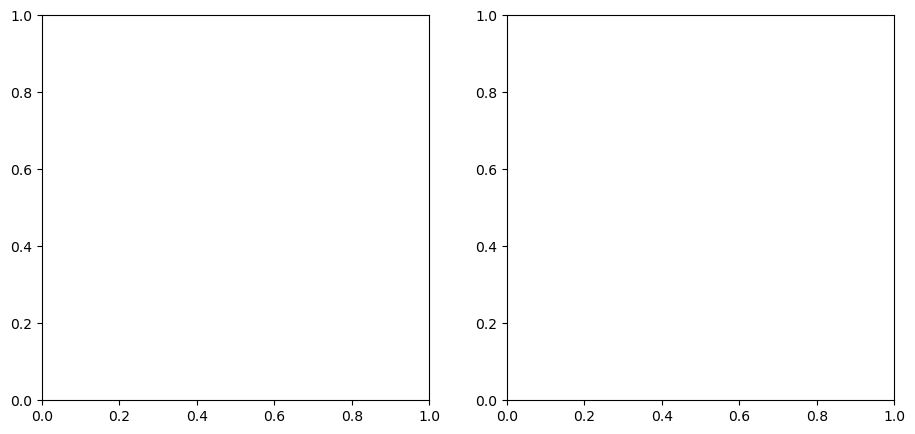

In [11]:
fields = ['unwrappedPhase', 'maskedUnwrappedPhase']
fig, axes = plt.subplots(1, len(fields), figsize=(11, 5))
for field, ax in zip(fields, axes.flatten()):
    data = getattr(myRIFG, field) 
    vmin, vmax = autoScaleRange(data, 95)
    h = ax.imshow(data, vmin=vmin, vmax=vmax, extent=myRIFG.extentLL, aspect='auto', origin='lower')
    colorBar(h, ax, '', 'right', '5%',.05, 12, 12, extend='both')
    ax.locator_params(axis='x', nbins=4)
    ax.set_title(field)
    ax.set_xlabel('Slant Range (m)')
    ax.set_ylabel('Zero Doppler Time (s)')
fig.tight_layout()

### Mask File

Its often useful to apply a mask from elsewhere. For example, a water mask. If the mask is saved with the same geometry as the unwrapped phase, this can be done with `myRIFG.applyMask`. As an example, the following will make a mask fild based on the correlation.

In [ ]:
mask = np.ones(myRIFG.unwrappedPhase.shape, dtype='u1')
mask[myRIFG.coherenceMagnitude < 0.15] = 0
with open('mask', 'w') as fpOut:
    mask.tofile(fpOut)
drv = gdal.GetDriverByName("VRT")
vrt = drv.Create('mask.vrt', myRIFG.MLRangeSize, myRIFG.MLAzimuthSize, bands=0, eType=gdal.GDT_Byte)
vrt.SetGeoTransform([-0.5, 1., 0., -0.5, 0., 1.])
options = [f"SourceFilename=mask", "relativeToVRT=1", "subclass=VRTRawRasterBand"]
vrt.AddBand(gdal.GDT_Byte, options=options)
band = vrt.GetRasterBand(1)
vrt = None

Now the mask can be applied as shown below. Note if a mask as already been applied as in the example above, this masking will be combined with the prior mask.

In [ ]:
myRIFG.applyMask('mask.vrt')

Here is the result.

In [ ]:
fields = ['unwrappedPhase', 'maskedUnwrappedPhase']
fig, axes = plt.subplots(1, len(fields), figsize=(10, 5))
for field, ax in zip(fields, axes.flatten()):
    data = getattr(myRIFG, field) 
    vmin, vmax = autoScaleRange(data, 95)
    h = ax.imshow(data, vmin=vmin, vmax=vmax, origin='lower')
    colorBar(h, ax, '', 'right', '5%',.05, 12, 12, extend='both')
    ax.set_title(field)
    ax.axis('off')

## Metadata Interpolation

Much of the spatially dependent information (e.g., incidenceAngle) is stored at meta data cubes (see nisar documenation). These cubes can be interpolatated to obtain the slantRange, alongTrack, and elevation dependent results. Here are examples of how to extract these data for the offset grids.

In each case, an interpolator is setup. Once the setup has occurred, you can interpolated `myRIFG.interpolatorCubeName([[z, zeroDopplerTime, slantRange]])`. Interpolating to a grid can be acomplished by `myRIFG.interpGrid(myRIFG.interpolatorCubeName, zGrid, zeroDopplerGrid, slantRangeGrid)`.

**Note for speed when they are not needed, most of the interpolators and grids need to be explicitly initialized before use as shown below**

### Setup Grid for the Offsets

The **RIFG** products do not include the DEM. At present, options are to assume zero (or other constant) elevation, map a DEM into R/D coordinates, interpolate the R/D dem included with the RUNW product. For simplicity, the rest of the notebook assumes 0 elevation.

In [ ]:
z = np.zeros(myRIFG.wrappedInterferogram.shape)

Next, a range/Dopper grid corresponding to the offset maps is created.

In [ ]:
myRIFG.setupRangeDopplerGrid()
fig, axes = plt.subplots(1, 2, figsize=(11, 5))
axes[0].imshow(myRIFG.zeroDopplerGrid, origin='lower', extent=myRIFG.extentLL, aspect='auto')
axes[1].imshow(myRIFG.slantRangeGrid, origin='lower', extent=myRIFG.extentLL, aspect='auto')
for ax, field in zip(axes, ['zeroDopplerGrid', 'slantRangeGrid']):
    ax.locator_params(axis='x', nbins=4)
    ax.set_title(field)
    ax.set_xlabel('Slant Range (m)')
    ax.set_ylabel('Zero Doppler Time (s)')
fig.tight_layout()

### Incidence and Elevation Angles

The incidence and elevation angles can be computed as follows:

In [ ]:
incidenceAngle = myRIFG.incidenceAngleCube(myRIFG.slantRangeGrid, myRIFG.zeroDopplerGrid, z)
elevationAngle = myRIFG.elevationAngleCube(myRIFG.slantRangeGrid, myRIFG.zeroDopplerGrid, z)
fig, axes = plt.subplots(1, 2)
for ax, var, title in zip(axes.flatten(), [incidenceAngle, elevationAngle], ['incidenceAngle', 'elevationAngle']):
    ax.imshow(var, origin='upper')
    ax.set_title(title)
    print(f'{title} min/max: {np.nanmin(var):.3f} {np.nanmax(var):.3f}')

### Ground Track Velocity

The ground track velocty is found by:

In [ ]:
groundTrackVelocity=  myRIFG.groundTrackVelocityCube(myRIFG.slantRangeGrid, myRIFG.zeroDopplerGrid, z)
fig, ax = plt.subplots(1,1)
ax.imshow(groundTrackVelocity, origin='lower')
print(f'groundTrackVelocity min/max: {np.min(groundTrackVelocity):.3f} {np.max(groundTrackVelocity):.3f}')

### XY Values in the Projected Coordinate System

The `x` and `y` coordinate at corresponding to each slantRange and zeroDopplerTime coordiantes can be determined as:

In [ ]:
x, y =  myRIFG.xyCube(myRIFG.slantRangeGrid, myRIFG.zeroDopplerGrid, z)
fig, axes = plt.subplots(1, 2)
for ax, var, title in zip(axes.flatten(), [x, y], [f'$X_{{{myRIFG.epsg}}}$ Grid',f'$Y_{{{myRIFG.epsg}}}$ Grid']):
    ax.imshow(var, origin='upper')
    ax.set_title(title)
    print(f'{title} min/max: {np.nanmin(var):.3f} {np.nanmax(var):.3f}')

## Baseline Components

The perpendicular and parallel baseline components are computed as follows:

In [ ]:
bn, bp =  myRIFG.baselineCube(myRIFG.slantRangeGrid, myRIFG.zeroDopplerGrid, z)
fig, axes = plt.subplots(1, 2)
for ax, var, title in zip(axes.flatten(), [bn, bp], ['bn', 'bp']):
    ax.imshow(var, origin='lower')
    ax.set_title(title)
    print(f'{title} min/max: {np.nanmin(var):.3f} {np.nanmax(var):.3f}')

### Along Track Unit Vector and LOS Unit Vector

The x and y components of the line-of-sight and along-track unit vector can be determined on the offset grid by:

In [ ]:
ATx, ATy =  myRIFG.alongTrackUnitVectorCube(myRIFG.slantRangeGrid, myRIFG.zeroDopplerGrid, z)
LOSx, LOSy=  myRIFG.losUnitVectorCube(myRIFG.slantRangeGrid, myRIFG.zeroDopplerGrid, z)
#
fig, axes = plt.subplots(1, 4, figsize=(15,5))
for ax, var, title in zip(axes.flatten(), [ATx, ATy, LOSx, LOSy], ['Along Track Vel. X', 'Along Track Vel. Y', 'LOS X', 'LOS Y']):
    ax.imshow(var, origin='lower')
    ax.set_title(title)

## Other Meta Data

Most of the essential meta data has been parsed and demonstrated in the examples above. Other quantities can be extracted by keyword from the h5 files. For example, the **centerFrequency** can be extracted as:

In [ ]:
np.array(myRIFG.h5['RIFG']['metadata']['processingInformation']['inputs']['l1ReferenceSlcGranules']).item().decode()

Note in the above example, `h5` has bypassed the `science` and `LSAR` levels for brevity. To access the h5 object from the the top, use `myRIFG.h5Full`. See the NISAR documentation or open the h5 file with a viewer to see all of the data fields. 

## Save Data to Binary or Tiff Files.

The data from the hdf can be save as individual tiffs, bound together by a single vrt file. The default is to write all of the bands e.,g `'coherenceMagnitude', 'connectedComponents', 'ionospherePhaseScreen', 'ionospherePhaseScreenUncertainty',' and `'unwrappedPhase'` for a **RIFG** product, which is accomplished as follows.

In the previous example, the results were save as tiffs. To save as binary files, run with `tiff=False` for a more limited set of bands:

In [ ]:
myRIFG.writeData('output/RIFGBinary', bands=['coherenceMagnitude', 'wrappedInterferogram'], tiff=False)
!ls -l output/RIFGTiff*

The data can be read back in as an `rioxarray`  using `nisarhdf.readVrtAsXarray`, which saves each band as a named data variable. The results can be displayed using the `xarray` version of `imshow`.

In [ ]:
RIFGbinary = nisarhdf.readVrtAsXarray('output/RIFGbinary.vrt', mask_and_scale=True)
#extent = [np.min(RIFGbinary.x), np.max(RIFGbinary.x), np.min(RIFGbinary.y), np.max(RIFGbinary.y)
# Get the band names
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
RIFGbinary.coherenceMagnitude.plot.imshow(ax=axes[0], cmap='gray')
RIFGbinary.unwrappedPhase.plot.imshow(ax=axes[1], cmap='RdBu_r')
RIFGbinary

## Save Gridded Data Cubes

The gridded data cubes can also be saved as either flat binary or as cloud-optimized geotiff (COG) files. In this case, use `save=True` to save the result internally, and then use `writeData` to save data the same way the other bands are saved. In the example below, the data are saved as COGs.

In [ ]:
myRIFG.incidenceAngleCube(myRIFG.slantRangeGrid, myRIFG.zeroDopplerGrid, z, save=True);
myRIFG.elevationAngleCube(myRIFG.slantRangeGrid, myRIFG.zeroDopplerGrid, z, save=True);
myRIFG.writeData('output/RIFGangles',bands=['incidenceAngle', 'elevationAngle'], tiff=True) # ', 'elevationAngle'

In [ ]:
RIFGTiff = nisarhdf.readVrtAsXarray('output/RIFGangles.vrt', mask_and_scale=True)
#extent = [np.min(RIFGbinary.x), np.max(RIFGbinary.x), np.min(RIFGbinary.y), np.max(RIFGbinary.y)
# Get the band names
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
RIFGTiff.incidenceAngle.plot.imshow(ax=axes[0])
RIFGTiff.elevationAngle.plot.imshow(ax=axes[1])
RIFGTiff

# Anything below here is debug code that can be ignored